In [1]:
# imports
import numpy as np
import pandas as pd
import requests
import logging

# finance
import yfinance as yf
import pandas_datareader as pdr
import talib as ta

# visualisation
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats

# time
import time
from datetime import date, datetime, timedelta 

from scipy.stats import weibull_min


In [2]:
# downloading crypto from binance
def get_coins():
        # set up logging to display info and error messages
        logging.basicConfig(
            level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
        )

        # download sol
        coin = ["SOLUSDT"]

        def fetch_crypto_ohlc(coin, interval="1d"):
            url = "https://api.binance.com/api/v1/klines"
        
            # 180 days back from today as it is max for binance api
            start_time = datetime.now() - timedelta(days=360)
            end_time = datetime.now()

            all_data = []

            while start_time < end_time:
                # define request parameters for binance api
                params = {
                    "symbol": coin,
                    "interval": interval,
                    "startTime": int(start_time.timestamp() * 1000),
                    "endTime": int(
                        (start_time + timedelta(days=90)).timestamp() * 1000
                    ),  # fetching 90 days at a time
                }

                response = requests.get(url, params=params)

                # check if request was successful
                if response.status_code != 200:
                    logging.error(f"Error fetching data for {coin}: {response.status_code}")
                    break

                data = response.json()

                # check if data is returned
                if not data:
                    logging.warning(f"No OHLC data found for {coin}.")
                    break

                all_data.extend(data)

                # update start time for next request
                start_time = pd.to_datetime(data[-1][0], unit="ms") + timedelta(
                    milliseconds=1
                )

                logging.info(f"Fetched data for {coin} up to {start_time}")
                time.sleep(0.5)  # pause to avoid api limits

            if not all_data:
                return pd.DataFrame()

            # convert data into df with appropriate column names
            ohlc_df = pd.DataFrame(
                all_data,
                columns=[
                    "timestamp",
                    "open",
                    "high",
                    "low",
                    "close",
                    "volume",
                    "close_time",
                    "quote_asset_volume",
                    "number_of_trades",
                    "taker_buy_base_asset_volume",
                    "taker_buy_quote_asset_volume",
                    "ignore",
                ],
            )

            # columns
            ohlc_df["ticker"] = coin

            ohlc_df["timestamp"] = pd.to_datetime(ohlc_df["timestamp"], unit="ms")
            ohlc_df.set_index("timestamp", inplace=True)

            # convert price and volume to float
            ohlc_df[["open", "high", "low", "close", "volume"]] = ohlc_df[["open", "high", "low", "close", "volume"]].astype(float)
            ohlc_df["price_change"] = (ohlc_df["close"] - ohlc_df["open"]) / ohlc_df["open"] * 100
            
            return ohlc_df[
                [
                    "ticker",
                    "open",
                    "high",
                    "low",
                    "close",
                    "price_change",
                    "volume"
                ]
            ]

        def generate_datetime_features(df):

            # generate additional datetime features
            df["year"] = df.index.year.astype(int)
            df["month"] = df.index.month.astype(int)
            df["day"] = df.index.dayofweek.astype(int)
            df["hour"] = df.index.hour.astype(int)

            return df

        # main script
        all_data = pd.DataFrame()

        for coin in coin:
            logging.info(f"Fetching data for {coin}")
            df = fetch_crypto_ohlc(coin)

            if not df.empty:
                df = generate_datetime_features(df)
                all_data = pd.concat([all_data, df])
            else:
                logging.warning(f"No data fetched for {coin}")

        # reorder columns to have datetime features at the beginning
        datetime_features = ["year", "month", "day", "hour", "ticker"]
        other_columns = [col for col in all_data.columns if col not in datetime_features]
        all_data = all_data[datetime_features + other_columns]

        all_data['ticker'] = all_data['ticker'].astype('category')

        # save df to csv
        all_data.to_csv('sol2.csv', index=True)
        logging.info("Data fetching and processing complete. Data saved to crypto.csv")

        all_data.info()

        all_data.describe()

if __name__ == "__main__":
        get_coins()


2025-06-12 08:06:02,783 - INFO - Fetching data for SOLUSDT
2025-06-12 08:06:03,162 - INFO - Fetched data for SOLUSDT up to 2024-09-15 00:00:00.001000
2025-06-12 08:06:03,974 - INFO - Fetched data for SOLUSDT up to 2024-12-14 00:00:00.001000
2025-06-12 08:06:04,785 - INFO - Fetched data for SOLUSDT up to 2025-03-14 00:00:00.001000
2025-06-12 08:06:05,613 - INFO - Fetched data for SOLUSDT up to 2025-06-12 00:00:00.001000
2025-06-12 08:06:06,531 - WARNING - No OHLC data found for SOLUSDT.
2025-06-12 08:06:06,556 - INFO - Data fetching and processing complete. Data saved to crypto.csv


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 2024-06-18 to 2025-06-12
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          360 non-null    int64   
 1   month         360 non-null    int64   
 2   day           360 non-null    int64   
 3   hour          360 non-null    int64   
 4   ticker        360 non-null    category
 5   open          360 non-null    float64 
 6   high          360 non-null    float64 
 7   low           360 non-null    float64 
 8   close         360 non-null    float64 
 9   price_change  360 non-null    float64 
 10  volume        360 non-null    float64 
dtypes: category(1), float64(6), int64(4)
memory usage: 31.4 KB


In [2]:
# daily returns

# calculate daily returns based on close price
df = pd.read_csv("sol.csv", parse_dates=True, index_col=0)
df["return"] = df["close"].pct_change() * 100

mean_return = df["return"].mean()
median_return = df["return"].median()
volatility = df["return"].std()
skewness = df["return"].skew()
kurtosis = df["return"].kurt()

daily_sharpe = mean_return / volatility
annual_sharpe = daily_sharpe * np.sqrt(365)

print(f"Mean return: {mean_return:.2f}")
print(f"Median return: {median_return:.2f}")
print(f"Volatility: {volatility:.2f}")
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")
print(f"Daily Sharpe: {daily_sharpe:.2f}")
print(f"Annual Sharpe: {annual_sharpe:.2f}")

Mean return: 0.14
Median return: 0.04
Volatility: 4.58
Skewness: 0.44
Kurtosis: 3.78
Daily Sharpe: 0.03
Annual Sharpe: 0.60


In [3]:
# quantile
q1 = df["return"].quantile(0.25)
q3 = df["return"].quantile(0.75)
print(f"Q1 (25%): {q1:.2f}")
print(f"Q3 (75%): {q3:.2f}")

# value at risk
quantiles = df["return"].quantile([0.05, 0.25, 0.5, 0.75, 0.95])
var_95 = df["return"].quantile(0.05)  # Value at Risk (95%)
var_99 = df["return"].quantile(0.01)  # Value at Risk (99%)

print(f"VaR 95%: {var_95:.2f}%")
print(f"VaR 99%: {var_99:.2f}%") 

Q1 (25%): -2.52
Q3 (75%): 2.63
VaR 95%: -6.70%
VaR 99%: -8.93%


In [4]:
# SOL shows positive expected returns (0.144% daily) but with high volatility (4.58%)
# distribution is right-skewed with fat tails, more extreme moves
# significant downside risk: 5% chance of losing >6.7% in a single day
# decent risk-adjusted returns (Sharpe 0.60) 
# strong outliers, suggesting momentum and mean-reversion opportunities


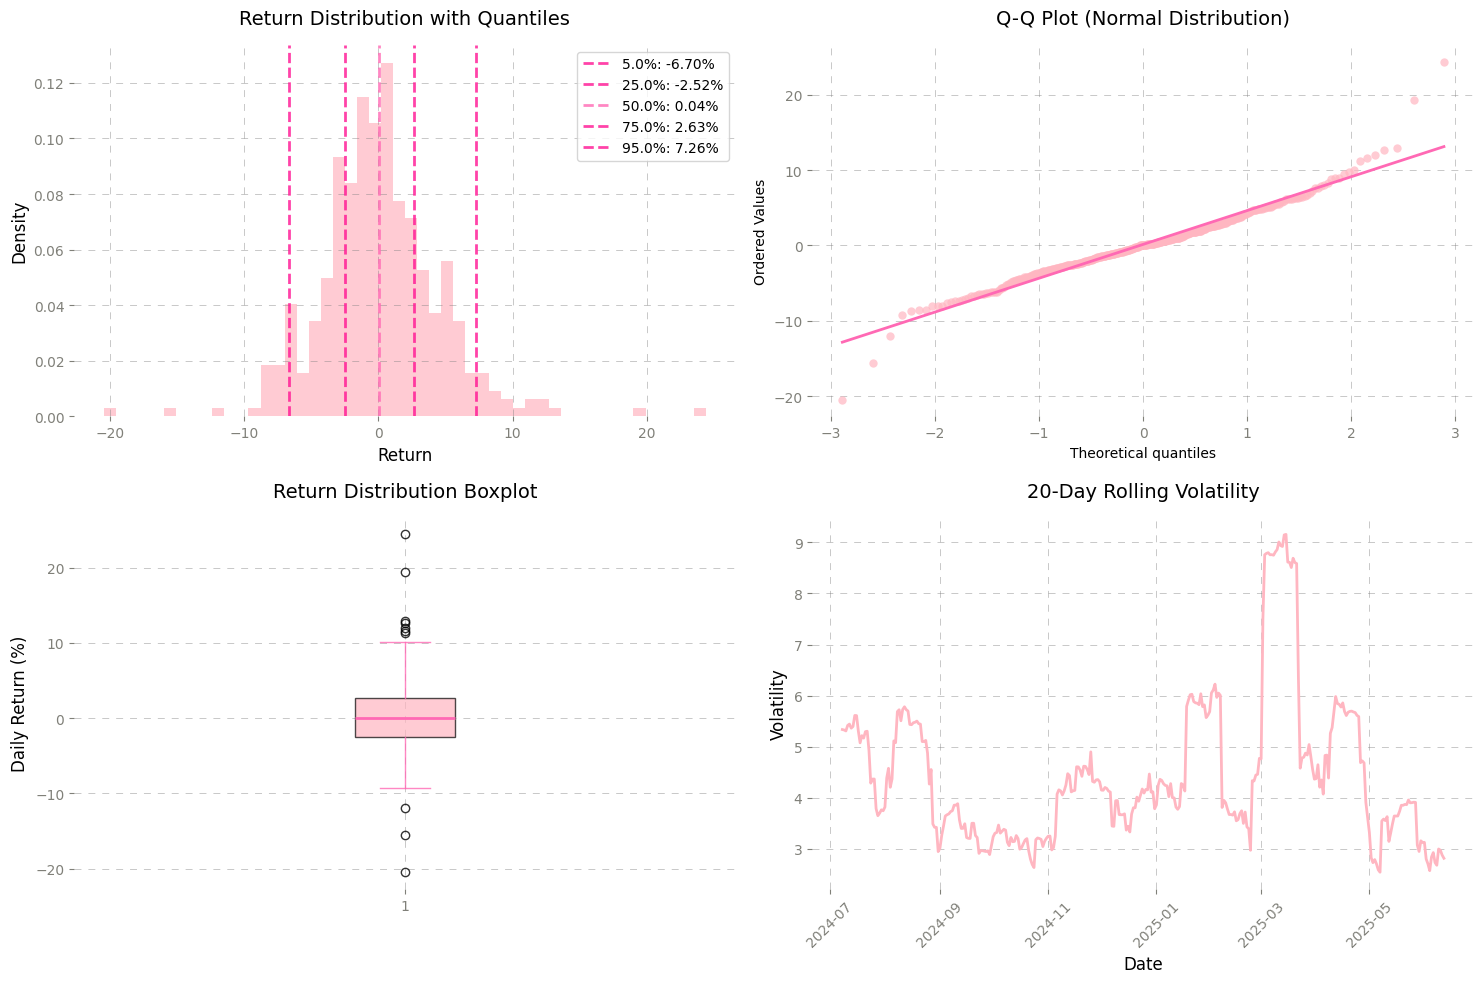

In [5]:
# visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Style settings
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 12

# histogram return
axes[0,0].hist(df["return"].dropna(), bins=50, alpha=0.7, density=True, 
               color='#FFB6C1', edgecolor='none')
for i, q_val in enumerate([0.05, 0.25, 0.5, 0.75, 0.95]):
    color = '#FF69B4' if i == 2 else '#FF1493'  # Median hervorheben
    axes[0,0].axvline(df["return"].quantile(q_val), 
                      color=color, linestyle='--', alpha=0.8, linewidth=2,
                      label=f'{q_val*100}%: {df["return"].quantile(q_val):.2f}%')
axes[0,0].set_title("Return Distribution with Quantiles", fontsize=14, pad=15)
axes[0,0].legend(fontsize=10)
axes[0,0].set_xlabel("Return", fontsize=12)
axes[0,0].set_ylabel("Density", fontsize=12)

# q-q plot normal distribution 
stats.probplot(df["return"].dropna(), dist="norm", plot=axes[0,1])
axes[0,1].get_lines()[0].set_markerfacecolor('#FFB6C1')
axes[0,1].get_lines()[0].set_markeredgecolor('none')
axes[0,1].get_lines()[0].set_alpha(0.7)
axes[0,1].get_lines()[1].set_color('#FF69B4')
axes[0,1].get_lines()[1].set_linewidth(2)
axes[0,1].set_title("Q-Q Plot (Normal Distribution)", fontsize=14, pad=15)

# box plot
bp = axes[1,0].boxplot(df["return"].dropna(), patch_artist=True)
bp['boxes'][0].set_facecolor('#FFB6C1')
bp['boxes'][0].set_alpha(0.7)
bp['medians'][0].set_color('#FF69B4')
bp['medians'][0].set_linewidth(2)
for element in ['whiskers', 'fliers', 'caps']:
    for item in bp[element]:
        item.set_color('#FF69B4')
        item.set_alpha(0.8)
axes[1,0].set_ylabel("Daily Return (%)", fontsize=12)
axes[1,0].set_title("Return Distribution Boxplot", fontsize=14, pad=15)

# rolling volatility
df["rolling_vol"] = df["return"].rolling(window=20).std()
axes[1,1].plot(df.index, df["rolling_vol"], color='#FFB6C1', linewidth=2)
axes[1,1].set_title("20-Day Rolling Volatility", fontsize=14, pad=15)
axes[1,1].set_ylabel("Volatility", fontsize=12)
axes[1,1].set_xlabel("Date", fontsize=12)

# Apply styling to all subplots
for ax in axes.flatten():
    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # Grid
    ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
    
    # Tick colors
    [t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
    [t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]
    
    # Tick styling
    ax.tick_params(axis="x", colors="#808079")
    ax.tick_params(axis="y", colors="#808079")

# Special handling for the last subplot (date axis)
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [6]:
# key insights:

# distribution analysis: 
# returns show normal distribution in the center but with significant fat tails 
# extreme price movements occur much more frequently than normal distribution would predict
# makes traditional VaR models unreliable

# qq plot: 
# deviation from the red line at extremes confirms fat-tail behavior
# Standard risk models will consistently underestimate actual risk exposure

# box plot: 
# numerous outliers beyond typical range, both positive and negative

# volatility clustering: 
# low volatility periods followed by high volatility spikes, particularly visible in early 2025
# high volatility periods cluster together
#quiet phases (3-4%) alternating with turbulent periods (up to 9%)
# volatility forecasting models could be highly valuable

#strategic implications:

# dynamic position sizing based on current volatility regime
# fat tail risk models instead of normal distribution assumptions
# volatility based strategy switching (conservative in high-vol, aggressive in low-vol periods)
# volatility (<3%): bigger positions
# volatilität (>6%): smaller positions
# trading vol breakouts from <3% to >5% after that bigger movements tend to follow
# contrarian position nach 8% move


In [7]:
# creating new columns, with shift(1) to avoid data leakage and focussed on volatility

# volatility 

df['volatility_7d'] = df['close'].rolling(window=7).std().shift(1)
df['volume_change'] = df['volume'].pct_change().replace([np.inf, -np.inf], np.nan).shift(1)

# volatility regime detection
df['vol_regime'] = np.where(df['volatility_7d'] > df['volatility_7d'].rolling(30).quantile(0.75), 2,  # High vol
                   np.where(df['volatility_7d'] < df['volatility_7d'].rolling(30).quantile(0.25), 0, 1))  # Low/Medium vol

# volatility momentum 
df['vol_momentum'] = df['volatility_7d'] / df['volatility_7d'].rolling(14).mean().shift(1) - 1

# extreme move detection 
df['extreme_down'] = (df['return'] < df['return'].rolling(252).quantile(0.05).shift(1)).astype(int)
df['extreme_up'] = (df['return'] > df['return'].rolling(252).quantile(0.95).shift(1)).astype(int)

# volatility regime transitions
df['vol_regime_change'] = (df['vol_regime'] != df['vol_regime'].shift(1)).astype(int)

# mean reversion after extremes
df['extreme_reversal_setup'] = ((df['extreme_down'].shift(1) == 1) & 
                                (df['return'] > 0)).astype(int)

# volatility expansion 
df['vol_expansion'] = (df['volatility_7d'] > df['volatility_7d'].shift(1) * 1.5).astype(int)

# fat tails
# Consecutive Extreme Days
extreme_events = (df['extreme_down'] | df['extreme_up']).astype(int)
df['extreme_streak'] = extreme_events.groupby((extreme_events != extreme_events.shift()).cumsum()).cumsum()

# Volume Anomalies (oft vor extremen Bewegungen)
df['volume_zscore'] = ((df['volume'] - df['volume'].rolling(30).mean()) / 
                       df['volume'].rolling(30).std()).shift(1)
df['volume_spike'] = (df['volume_zscore'] > 2).astype(int)

df['trend_alignment'] = ((df['close'] > df['close'].shift(1)) &
                         (df['close'] > df['close'].shift(7))).astype(int)

# breakout last 7 days
df['breakout_high_7d'] = (df['close'] > df['high'].rolling(window=7).max().shift(1)).astype(int)
# strategy implication, combining volatility volume = strong breakout-signal
df['breakout_signal'] = (df['vol_expansion'] == 1) & (df['volume_spike'] == 1)


# talib
def add_ta_indicators(df):
    # ensure columns have correct data types
    df["open"] = df["open"].astype("float64")
    df["high"] = df["high"].astype("float64")
    df["low"] = df["low"].astype("float64")
    df["close"] = df["close"].astype("float64")
    df["volume"] = df["volume"].astype("float64")

    # preventing leakage
    high_shift = df['high'].shift(1)
    low_shift = df['low'].shift(1)
    close_shift = df['close'].shift(1)
    open_shift = df['open'].shift(1)
    volume_shift = df['volume'].shift(1)
    
    # calculate technical indicators
    df['atr'] = ta.ATR(high_shift, low_shift, close_shift)
    df['atr_14'] = ta.ATR(high_shift, low_shift, close_shift, timeperiod=14)
    df['adx'] = ta.ADX(high_shift, low_shift, close_shift)  
    df['rsi'] = ta.RSI(close_shift)
    df['sma_30d'] = ta.SMA(close_shift, timeperiod=30)
    df['sma_50d'] = ta.SMA(close_shift, timeperiod=50)
    upper, middle, lower = ta.BBANDS(close_shift, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['bb_upper'] = upper
    df['bb_middle'] = middle
    df['bb_lower'] = lower
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    df['bb_position'] = (close_shift - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    df['ema_9'] = ta.EMA(close_shift, timeperiod=9)
    df['ema_21'] = ta.EMA(close_shift, timeperiod=21)
    return df

df = add_ta_indicators(df)


# rsi divergence 
df['rsi_oversold_extreme'] = (df['rsi'] < 20).astype(int)  
df['rsi_overbought_extreme'] = (df['rsi'] > 80).astype(int) 

# market stress
df['market_stress'] = (df['vol_regime'] == 2).astype(int) + \
                      (df['volume_zscore'] > 2).astype(int) + \
                      (df['extreme_streak'] > 1).astype(int)

# golden cross and death cross for ema 9 and ema 21
df['ema9_above_ema21'] = np.where(df['ema_9'] > df['ema_21'], 1, 0)
df['golden_cross_ema'] = np.where((df['ema9_above_ema21'] != df['ema9_above_ema21'].shift(1)) & df['ema9_above_ema21'], 1, 0)
df['death_cross_ema'] = np.where((df['ema9_above_ema21'] != df['ema9_above_ema21'].shift(1)) & ~df['ema9_above_ema21'], 1, 0)

# delete now unnecessary column
df.drop(columns=['ema9_above_ema21', 'atr'], inplace=True)

In [8]:
# checking if there are infinity data and replace with nan
infinity_check = df.replace([np.inf, -np.inf], np.nan).isnull().sum()

# print columns that have infinity
print("Columns with infinity:")
print(infinity_check[infinity_check > 0])

Columns with infinity:
return            1
rolling_vol      20
volatility_7d     7
volume_change     2
vol_momentum     21
volume_zscore    30
atr_14           15
adx              28
rsi              15
sma_30d          30
sma_50d          50
bb_upper         20
bb_middle        20
bb_lower         20
bb_width         20
bb_position      20
ema_9             9
ema_21           21
dtype: int64


In [9]:
print("Option 1: Replace infinity with NaN")
df = df.replace([np.inf, -np.inf], np.nan)

# Check how many NaN values we have now
nan_count = df.isnull().sum()
print("NaN values after infinity replacement:")
print(nan_count[nan_count > 0])

Option 1: Replace infinity with NaN
NaN values after infinity replacement:
return            1
rolling_vol      20
volatility_7d     7
volume_change     2
vol_momentum     21
volume_zscore    30
atr_14           15
adx              28
rsi              15
sma_30d          30
sma_50d          50
bb_upper         20
bb_middle        20
bb_lower         20
bb_width         20
bb_position      20
ema_9             9
ema_21           21
dtype: int64


In [10]:
# using forwardfill
df = df.ffill()
df = df.bfill()
print(df.isnull().sum().sum())



0


In [11]:
df.head(3)

,year,month,day,hour,ticker,open,high,low,close,price_change,...,bb_lower,bb_width,bb_position,ema_9,ema_21,rsi_oversold_extreme,rsi_overbought_extreme,market_stress,golden_cross_ema,death_cross_ema
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-06-18,2024,6,1,0,SOLUSDT,143.28,143.82,127.95,137.41,-4.096873,...,124.648683,0.196321,0.257653,134.364444,138.291905,0,0,0,0,1
2024-06-19,2024,6,2,0,SOLUSDT,137.41,141.90,134.47,135.62,-1.302671,...,124.648683,0.196321,0.257653,134.364444,138.291905,0,0,0,0,0
2024-06-20,2024,6,3,0,SOLUSDT,135.62,141.29,131.90,133.55,-1.526324,...,124.648683,0.196321,0.257653,134.364444,138.291905,0,0,0,0,0


month               :  0.031
open                : -0.101
high                : -0.105
low                 : -0.097
close               : -0.111
price_change        : -0.068
volume              :  0.003
rolling_vol         : -0.039
volatility_7d       :  0.005
volume_change       :  0.002
vol_momentum        :  0.019
volume_zscore       :  0.081
atr_14              : -0.096
adx                 : -0.080
rsi                 : -0.030
sma_30d             : -0.098
sma_50d             : -0.091
bb_upper            : -0.091
bb_middle           : -0.092
bb_lower            : -0.086
bb_width            : -0.028
bb_position         : -0.011
ema_9               : -0.101
ema_21              : -0.100

Stärkste Korrelationen:
close               : -0.111
high                : -0.105
open                : -0.101
ema_9               : -0.101
ema_21              : -0.100


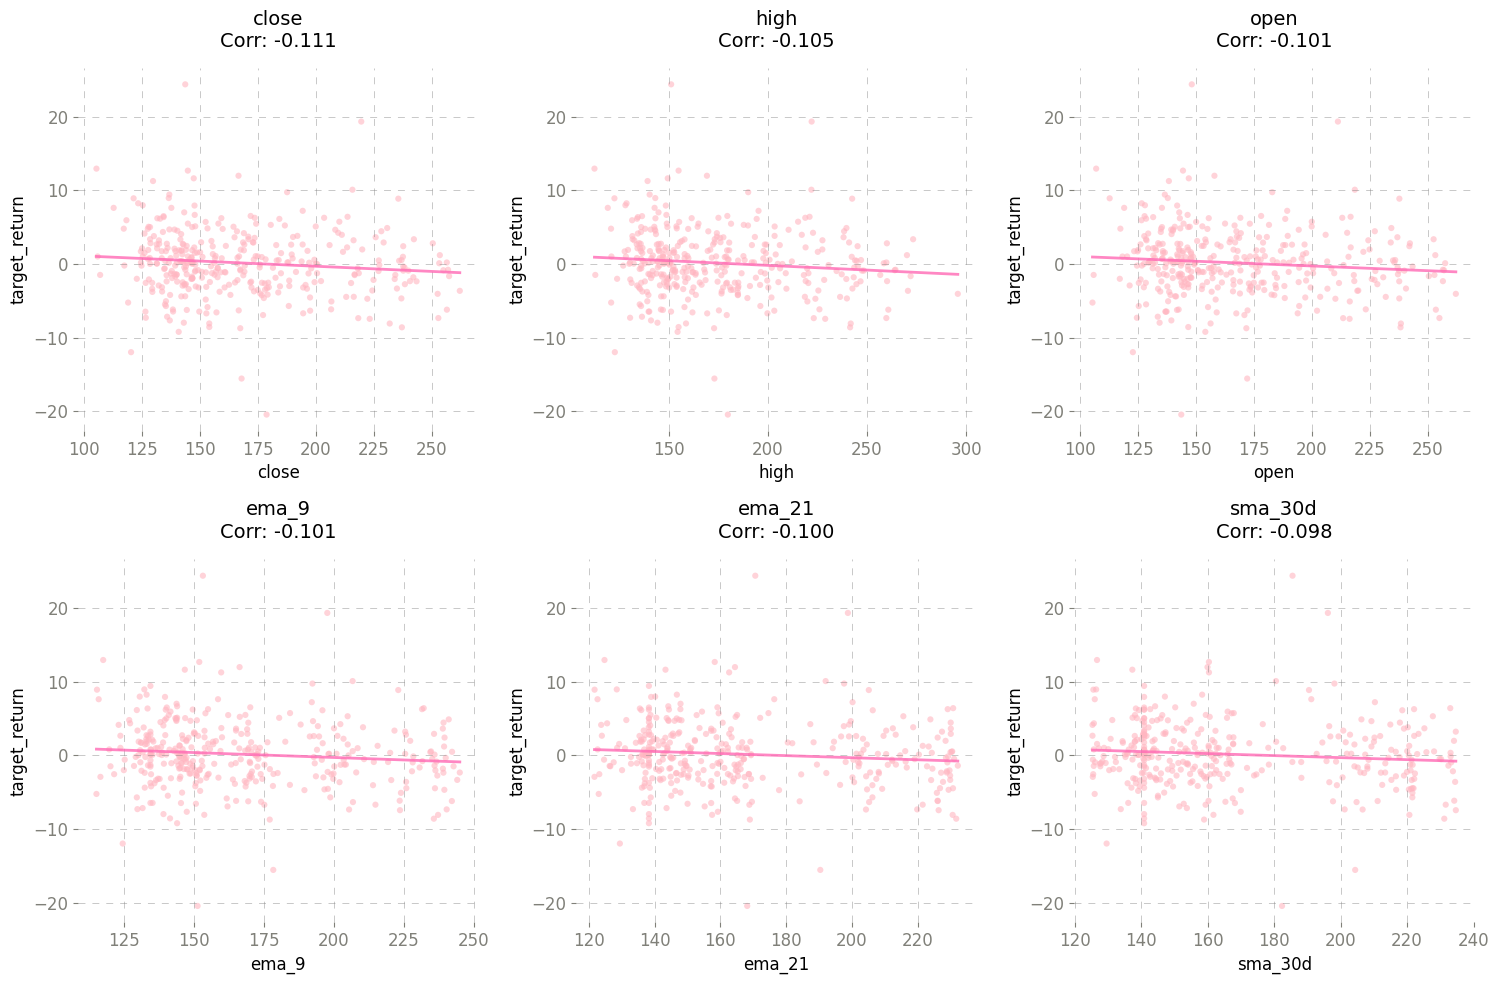

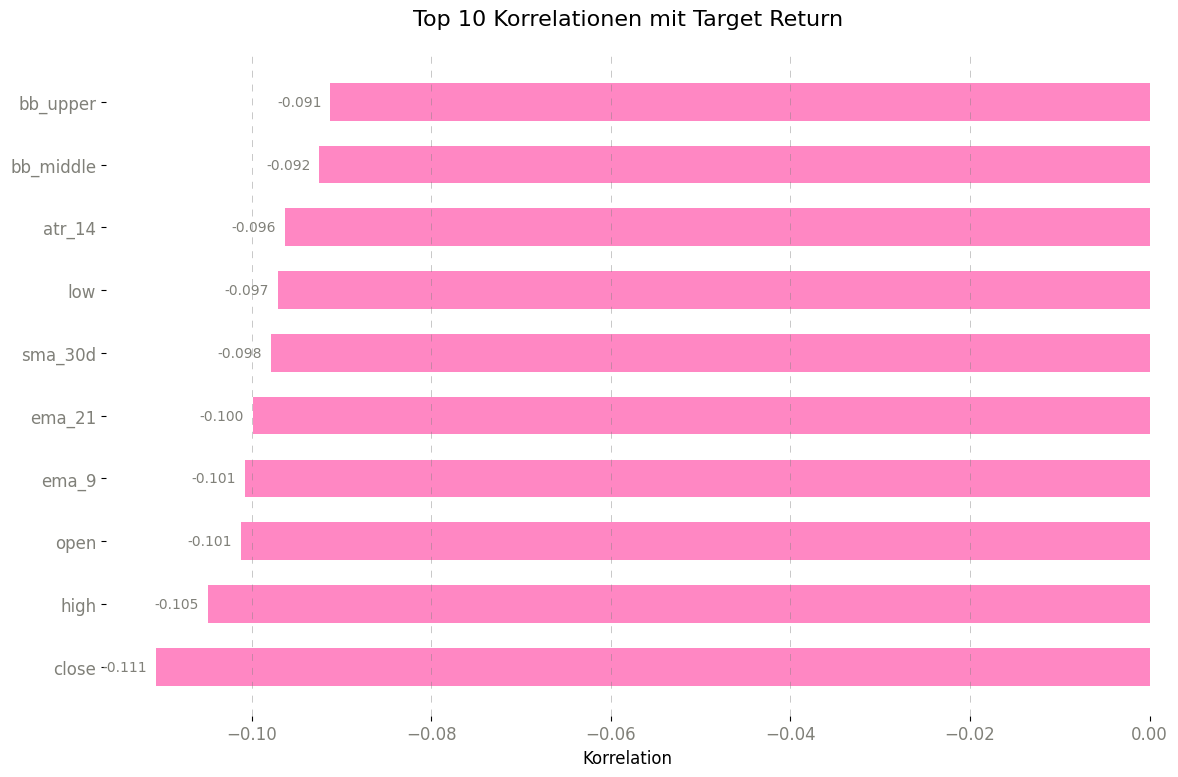


Features mit abs(corr) > 0.05: ['open', 'high', 'low', 'close', 'price_change', 'volume_zscore', 'atr_14', 'adx', 'sma_30d', 'sma_50d', 'bb_upper', 'bb_middle', 'bb_lower', 'ema_9', 'ema_21']
Das sind 15 von 24 Features


In [12]:
# 1. Simple Correlation Check
df['target_return'] = df['return'].shift(-1)
indicators = [
    col for col in df.select_dtypes(include='number').columns
    if df[col].nunique() > 10 and col not in ['return', 'target_return']
]

correlations = {}
for indicator in indicators:
    corr = df[indicator].corr(df['target_return'])
    correlations[indicator] = corr
    print(f"{indicator:20s}: {corr:6.3f}")

# Sortiert nach stärkster Korrelation
sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print("\nStärkste Korrelationen:")
for indicator, corr in sorted_corr[:5]:
    print(f"{indicator:20s}: {corr:6.3f}")

# 2. Visual Check für Linearität (nur Top 6) - Im gewünschten Stil
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Style settings
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 12

for i, (indicator, corr) in enumerate(sorted_corr[:6]):
    # Scatter plot mit style
    axes[i].scatter(df[indicator], df['target_return'], 
                   alpha=0.6, color='#FFB6C1', s=20, edgecolors='none')
    
    # Title styling
    axes[i].set_title(f'{indicator}\nCorr: {corr:.3f}', fontsize=14, pad=15)
    axes[i].set_xlabel(indicator, fontsize=12)
    axes[i].set_ylabel('target_return', fontsize=12)
    
    # Trend line
    valid_mask = df[indicator].notna() & df['target_return'].notna()
    if valid_mask.sum() > 1:
        z = np.polyfit(df[indicator][valid_mask], df['target_return'][valid_mask], 1)
        p = np.poly1d(z)
        x_trend = np.linspace(df[indicator].min(), df[indicator].max(), 100)
        axes[i].plot(x_trend, p(x_trend), color='#FF69B4', linewidth=2, alpha=0.8)
    
    # Style axes
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    
    # Grid
    axes[i].grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
    
    # Tick colors
    [t.set_color('#808079') for t in axes[i].yaxis.get_ticklabels()]
    [t.set_color('#808079') for t in axes[i].xaxis.get_ticklabels()]
    
    # Tick styling
    axes[i].tick_params(axis="x", colors="#808079")
    axes[i].tick_params(axis="y", colors="#808079")

plt.tight_layout()
plt.show()

# 3. Correlation Bar Chart - Zusätzliche Visualisierung im Stil
plt.figure(figsize=(12, 8))

# Top 10 Korrelationen für bessere Übersicht
top_corr = sorted_corr[:10]
indicators_names = [item[0] for item in top_corr]
corr_values = [item[1] for item in top_corr]

# Bar plot mit custom styling
bars = plt.barh(range(len(indicators_names)), corr_values, 
                color=['#FFB6C1' if x >= 0 else '#FF69B4' for x in corr_values],
                alpha=0.8, height=0.6)

# Styling
plt.title('Top 10 Korrelationen mit Target Return', fontsize=16, pad=20)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14

plt.yticks(range(len(indicators_names)), indicators_names)
plt.xlabel('Korrelation', fontsize=12)

# Style axes
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Grid
ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6, axis='x')

# Colour ticks
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# Add correlation values as text
for i, (bar, corr) in enumerate(zip(bars, corr_values)):
    plt.text(corr + 0.001 if corr >= 0 else corr - 0.001, i, 
             f'{corr:.3f}', va='center', 
             ha='left' if corr >= 0 else 'right', 
             color='#808079', fontsize=10)

plt.tight_layout()
plt.show()

# 4. Welche sind wirklich linear? (einfacher Test)
linear_features = []
for indicator, corr in correlations.items():
    if abs(corr) > 0.05:  # Mindest-Korrelation
        linear_features.append(indicator)

print(f"\nFeatures mit abs(corr) > 0.05: {linear_features}")
print(f"Das sind {len(linear_features)} von {len(indicators)} Features")

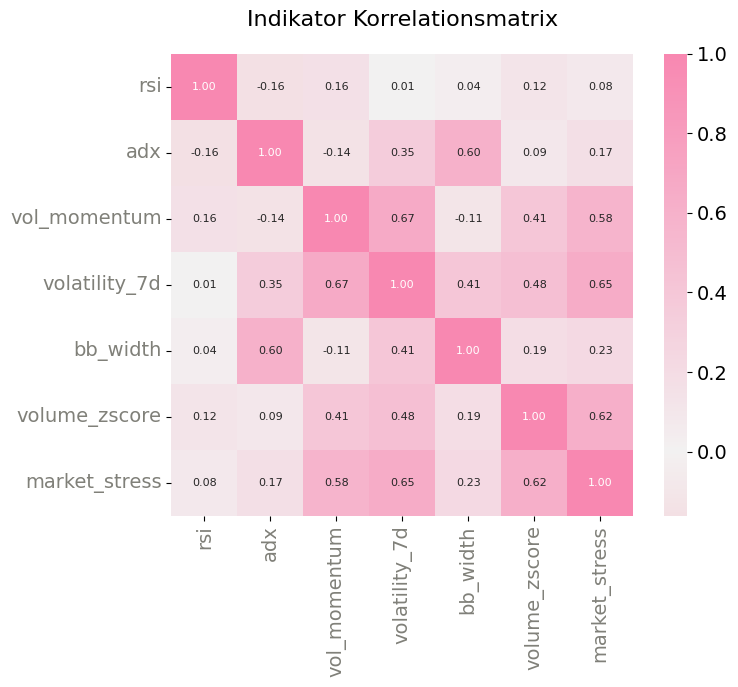

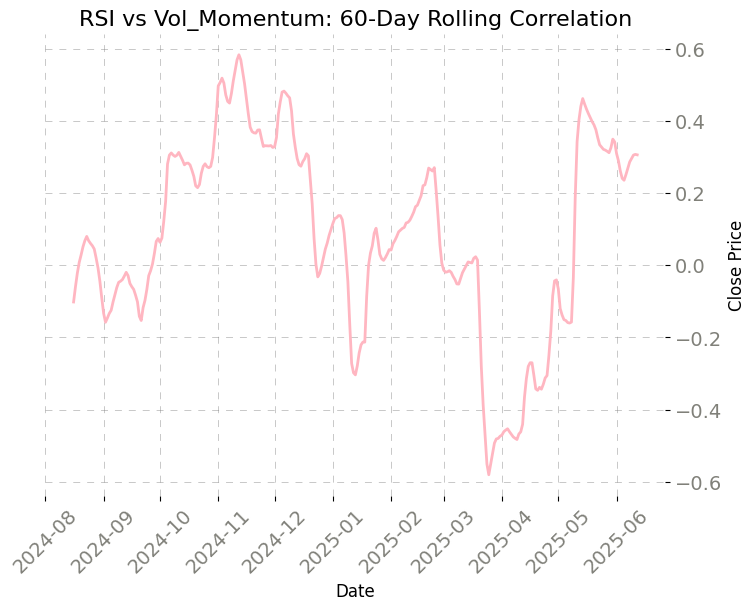

In [13]:
# correlation
indicators = ['rsi', 'adx', 'vol_momentum', 'volatility_7d', 
              'bb_width', 'volume_zscore', 'market_stress']

corr_matrix = df[indicators].corr()

# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
  corr_matrix,
  annot=True,
  cmap=sns.diverging_palette(h_neg=0, h_pos=350, s=90, l=70, as_cmap=True), 
  center=0,
  fmt='.2f',
  square=True,
  annot_kws={'size': 8})
    
# style
plt.title("Indikator Korrelationsmatrix", fontsize=16, pad=20)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
ax = plt.gca()
# remove axis frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# colour ticks
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]






# rolling corr for time
rolling_corr = df['rsi'].rolling(60).corr(df['vol_momentum'])
plt.figure(figsize=(8, 6))

# plot
plt.plot(rolling_corr, color='#FFB6C1', linewidth=2)
plt.title('RSI vs Vol_Momentum: 60-Day Rolling Correlation', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticker
plt.xticks(rotation=45)
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
for t in ax.yaxis.get_ticklabels():
    t.set_color('#808079')
for t in ax.xaxis.get_ticklabels():
    t.set_color('#808079')



In [14]:
# correlation with vol regime
high_vol = df[df['vol_regime'] == 2]
low_vol = df[df['vol_regime'] == 0]

print("High Vol Regime - RSI vs Vol_Momentum:", 
      high_vol['rsi'].corr(high_vol['vol_momentum']))
print("Low Vol Regime - RSI vs Vol_Momentum:", 
      low_vol['rsi'].corr(low_vol['vol_momentum']))

High Vol Regime - RSI vs Vol_Momentum: 0.16863776261780059
Low Vol Regime - RSI vs Vol_Momentum: -0.008151078610941644


In [15]:
# check for redudantant features
feature_cols = [col for col in df.columns if col not in ['target', 'ticker', 'open', 'high', 'low', 'close', 'return', 'volume', 'date']]
corr_matrix = df[feature_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Features to drop:")
print(to_drop)


Features to drop:
['sma_50d', 'bb_upper', 'bb_middle', 'bb_lower', 'ema_9', 'ema_21']


In [16]:
# key insights:
# remove vol_momentum ↔ volatility_7d: 0.71 cor 
# adx ↔ bb_width: 0.57 cor, keep both
# rsi week cor with other indicators, possible to use it as main indicator
# rolling cor varries between -0.6 and +0.6


In [17]:
# remove correlated columns
df.drop(columns=['vol_momentum', 'sma_50d', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_position', 'ema_9', 'ema_21'], inplace=True)


In [21]:
stats_columns = ['adx', 'rsi', 'sma_30d', 'vol_regime_change', 'vol_regime','vol_expansion', 'extreme_streak', 'volume_zscore', 'extreme_reversal_setup', ]
stats_summary = df[stats_columns].describe()
print("Statistical Summary:\n", stats_summary)

Statistical Summary:
               adx         rsi     sma_30d  vol_regime_change  vol_regime  \
count  360.000000  360.000000  360.000000         360.000000  360.000000   
mean    23.934631   51.863018  167.060108           0.236111    0.997222   
std      7.090799   11.576501   32.472759           0.425282    0.694180   
min     11.800950   24.744466  125.401333           0.000000    0.000000   
25%     19.019877   42.304806  140.926000           0.000000    1.000000   
50%     23.839122   51.761926  156.591667           0.000000    1.000000   
75%     28.933319   61.069243  197.830583           0.000000    1.000000   
max     44.963038   78.659643  234.657667           1.000000    2.000000   

       vol_expansion  extreme_streak  volume_zscore  extreme_reversal_setup  
count     360.000000      360.000000     360.000000              360.000000  
mean        0.075000        0.044444      -0.026046                0.008333  
std         0.263758        0.231796       1.005878        

In [22]:
# BAYES

In [23]:
# bayesian indicator analysis: calculates p(up|signal) vs baseline probability for binary trading indicators
# performance metrics: calculactes lift percentage, signal frequency, and statistical significance for each indicator
# visual analysis: heatmaps for probability, lift %, and frequency vs performance scatter plots
# signal combinations: tests combinations of best performing bullish/bearish indicators
# trading signal generation: filters significant indicators based on minimum lift and frequency thresholds

=== BAYES ANALYSIS FOR ALL INDICATORS ===
Baseline P(Up-Day) = 0.508
------------------------------------------------------------
vol_expansion             | P(Up|Signal)=0.444 | Lift=-0.064 (-12.6%) | Freq=0.075 | 🔴 BEARISH
volume_spike              | P(Up|Signal)=0.706 | Lift=+0.198 (+38.9%) | Freq=0.047 | 🟢 BULLISH
breakout_signal           | P(Up|Signal)=0.333 | Lift=-0.175 (-34.4%) | Freq=0.008 | 🔴 BEARISH
extreme_down              | P(Up|Signal)=0.600 | Lift=+0.092 (+18.0%) | Freq=0.014 | 🟢 BULLISH
extreme_up                | P(Up|Signal)=0.444 | Lift=-0.064 (-12.6%) | Freq=0.025 | 🔴 BEARISH
vol_regime_change         | P(Up|Signal)=0.447 | Lift=-0.061 (-12.1%) | Freq=0.236 | 🔴 BEARISH
golden_cross_ema          | P(Up|Signal)=0.286 | Lift=-0.223 (-43.8%) | Freq=0.019 | 🔴 BEARISH
death_cross_ema           | P(Up|Signal)=0.125 | Lift=-0.383 (-75.4%) | Freq=0.022 | 🔴 BEARISH
breakout_high_7d          | P(Up|Signal)=0.545 | Lift=+0.037 (+7.3%) | Freq=0.122 | ⚪ NEUTRAL
trend_alignment 

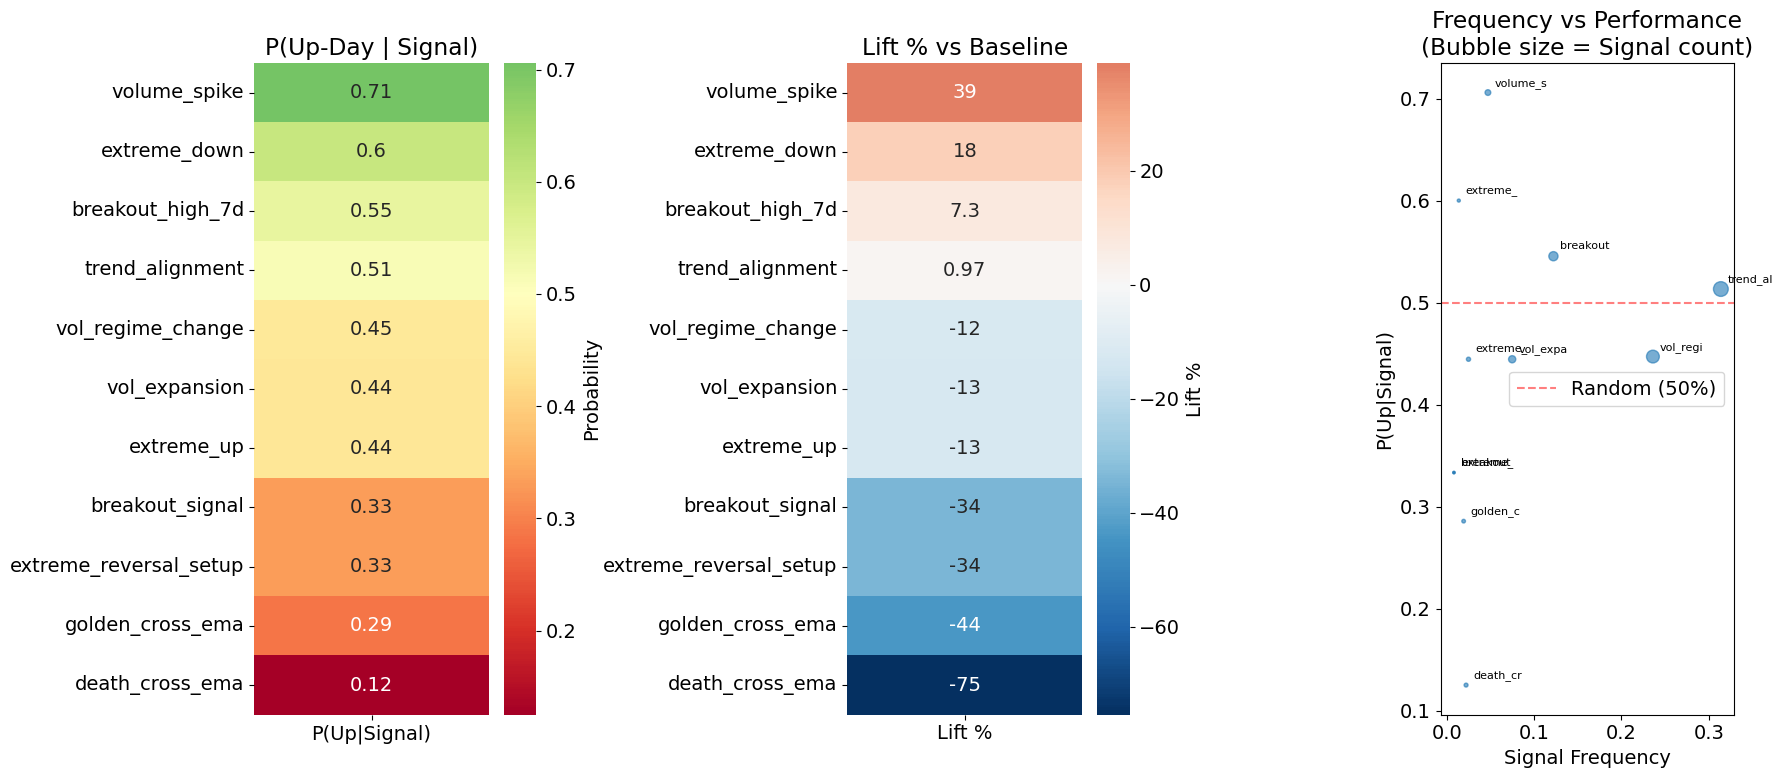


=== SIGNAL COMBINATIONS ===
Best bullish Signals: ['volume_spike', 'extreme_down']
Best bearish Signals: ['vol_expansion', 'breakout_signal', 'extreme_up', 'vol_regime_change', 'golden_cross_ema', 'death_cross_ema', 'extreme_reversal_setup']

--- BULLISH COMBINATIONS ---

--- BEARISH COMBINATIONS ---
vol_expansion + vol_regime_change: P(Up)=0.389, Count=18

=== TRADING SIGNALS (Min Lift: 0.05, Min Freq: 0.02) ===
STRONG SELL: vol_expansion (Lift: -0.064)
STRONG BUY: volume_spike (Lift: +0.198)
STRONG SELL: extreme_up (Lift: -0.064)
STRONG SELL: vol_regime_change (Lift: -0.061)
STRONG SELL: death_cross_ema (Lift: -0.383)


In [24]:
def comprehensive_bayes_analysis(df, target_col='target'):
  
    # define target
    if target_col not in df.columns:
        df[target_col] = (df['return'].shift(-1) > 0).astype(int)

    # binary indicators
    binary_indicators = [
        'vol_expansion', 'volume_spike', 'breakout_signal',
        'extreme_down', 'extreme_up', 'vol_regime_change',
        'rsi_oversold_extreme', 'rsi_overbought_extreme',
        'golden_cross_ema', 'death_cross_ema', 'breakout_high_7d',
        'trend_alignment', 'extreme_reversal_setup'
    ]
    
    # check indicators exist
    existing_indicators = [ind for ind in binary_indicators if ind in df.columns]
    
    print("=== BAYES ANALYSIS FOR ALL INDICATORS ===")
    print(f"Baseline P(Up-Day) = {df[target_col].mean():.3f}")
    print("-" * 60)
    
    results = {}
    
    for indicator in existing_indicators:
        try:
            # P(A): prob of up day
            p_A = df[target_col].mean()
            
            # P(B): prob of indicator = 1  
            p_B = (df[indicator] == 1).mean()
            
            if p_B > 0:  # avoid division by zero
                # P(B|A): prob of indicator=1 given up day
                p_B_given_A = df[df[target_col] == 1][indicator].mean()
                
                # P(A|B): bayes theorem
                p_A_given_B = (p_B_given_A * p_A) / p_B
                
                # additional metrics
                p_A_given_not_B = df[df[indicator] == 0][target_col].mean()
                
                # effect size (how much better/worse than baseline)
                lift = p_A_given_B - p_A
                lift_pct = (p_A_given_B / p_A - 1) * 100
                
                # signal frequency
                signal_freq = p_B
                
                results[indicator] = {
                    'P(Up|Signal)': p_A_given_B,
                    'P(Up|No Signal)': p_A_given_not_B,
                    'Lift': lift,
                    'Lift %': lift_pct,
                    'Signal Frequency': signal_freq,
                    'Signal Count': int(df[indicator].sum())
                }
                
                # interpretation
                if p_A_given_B > 0.55:
                    interpretation = "🟢 BULLISH"
                elif p_A_given_B < 0.45:
                    interpretation = "🔴 BEARISH"  
                else:
                    interpretation = "⚪ NEUTRAL"
                
                print(f"{indicator:25} | P(Up|Signal)={p_A_given_B:.3f} | "
                      f"Lift={lift:+.3f} ({lift_pct:+.1f}%) | "
                      f"Freq={signal_freq:.3f} | {interpretation}")
                      
        except Exception as e:
            print(f"Error analyzing {indicator}: {e}")
    
    return results

def create_bayes_heatmap(results):
    """
    visualisation heatmap
    """
    if not results:
        print("No results for heatmap.")
        return
        
    # convert for plotting
    df_results = pd.DataFrame(results).T
    
    # figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    
    # P(Up|Signal) heatmap
    prob_data = df_results[['P(Up|Signal)']].sort_values('P(Up|Signal)', ascending=False)
    sns.heatmap(prob_data, annot=True, cmap='RdYlGn', center=0.5, 
                ax=axes[0], cbar_kws={'label': 'Probability'})
    axes[0].set_title('P(Up-Day | Signal)')
    
    # lift heatmap  
    lift_data = df_results[['Lift %']].sort_values('Lift %', ascending=False)
    sns.heatmap(lift_data, annot=True, cmap='RdBu_r', center=0,
                ax=axes[1], cbar_kws={'label': 'Lift %'})
    axes[1].set_title('Lift % vs Baseline')
    
    # signal frequency vs performance
    axes[2].scatter(df_results['Signal Frequency'], df_results['P(Up|Signal)'], 
                   s=df_results['Signal Count'], alpha=0.6)
    axes[2].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random (50%)')
    axes[2].set_xlabel('Signal Frequency')
    axes[2].set_ylabel('P(Up|Signal)')
    axes[2].set_title('Frequency vs Performance\n(Bubble size = Signal count)')
    axes[2].legend()
    
    # add labels
    for indicator, row in df_results.iterrows():
        axes[2].annotate(indicator[:8], 
                        (row['Signal Frequency'], row['P(Up|Signal)']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()

def signal_combination_analysis(df, results, target_col='target'):
    """
    analysing combination of signals
    """
    print("\n=== SIGNAL COMBINATIONS ===")
    
    # find best bullish and bearish signals
    best_bullish = []
    best_bearish = []
    
    for indicator, metrics in results.items():
        if metrics['P(Up|Signal)'] > 0.55:
            best_bullish.append(indicator)
        elif metrics['P(Up|Signal)'] < 0.45:
            best_bearish.append(indicator)
    
    print(f"Best bullish Signals: {best_bullish}")
    print(f"Best bearish Signals: {best_bearish}")
    
    # test combinations
    if len(best_bullish) >= 2:
        print(f"\n--- BULLISH COMBINATIONS ---")
        for i, sig1 in enumerate(best_bullish[:-1]):
            for sig2 in best_bullish[i+1:]:
                combined = (df[sig1] == 1) & (df[sig2] == 1)
                if combined.sum() > 10:  # minimum 10 signals
                    prob_up = df[combined & df[target_col].notna()][target_col].mean()
                    count = combined.sum()
                    print(f"{sig1} + {sig2}: P(Up)={prob_up:.3f}, Count={count}")
    
    if len(best_bearish) >= 2:
        print(f"\n--- BEARISH COMBINATIONS ---")
        for i, sig1 in enumerate(best_bearish[:-1]):
            for sig2 in best_bearish[i+1:]:
                combined = (df[sig1] == 1) & (df[sig2] == 1)
                if combined.sum() > 10:
                    prob_up = df[combined & df[target_col].notna()][target_col].mean()
                    count = combined.sum()
                    print(f"{sig1} + {sig2}: P(Up)={prob_up:.3f}, Count={count}")

def trading_signals_from_bayes(df, results, min_lift=0.05, min_frequency=0.02):
    """
    trading signals based on bayes results
    """
    print(f"\n=== TRADING SIGNALS (Min Lift: {min_lift}, Min Freq: {min_frequency}) ===")
    
    # filter significant signals
    significant_bullish = []
    significant_bearish = []
    
    for indicator, metrics in results.items():
        if (metrics['Lift'] > min_lift and 
            metrics['Signal Frequency'] > min_frequency):
            significant_bullish.append(indicator)
            print(f"STRONG BUY: {indicator} (Lift: {metrics['Lift']:+.3f})")
            
        elif (metrics['Lift'] < -min_lift and 
              metrics['Signal Frequency'] > min_frequency):
            significant_bearish.append(indicator)
            print(f"STRONG SELL: {indicator} (Lift: {metrics['Lift']:+.3f})")
    
    # composite signals
    if significant_bullish:
        df['bayes_buy_signal'] = df[significant_bullish].sum(axis=1)
    
    if significant_bearish:
        df['bayes_sell_signal'] = df[significant_bearish].sum(axis=1)
    
    return df

results = comprehensive_bayes_analysis(df)

create_bayes_heatmap(results)

signal_combination_analysis(df, results)

df = trading_signals_from_bayes(df, results)


In [25]:
# findings:
# indicators are predominantly BEARISH, most signal market weakness 
# volume spike: 70.6% up probability (+38.9% lift), occurs 4.7% of time -> strong bullish indicator when unusual volume
# extreme down: 60% success rate (+18% lift) -> could be weighted heavier in strategy but very rare
# volume expansion: 44.4% up probability (-12.6% lift), occurs 7.5% of time -> expanding volume without direction is bearish
# extreme up: 44.4% up probability (-12.6% lift), occurs 2.5% of time -> overbought conditions lead to pullbacks
# death_cross_ema: reliable bearish signal (12.5% up rate, -75% lift) -> could be weighted heavier in strategy but very rare
# underperforming columns we can delete: breakout_signal, golden_cross_ema, extreme_reversal_setup, trend_alignment
# SHORT strategy: volume_spike, vol_expansion, vol_regime_change

In [26]:
# remove weak pred colums
df.drop(columns=['breakout_high_7d', 'golden_cross_ema', 'extreme_reversal_setup', 'trend_alignment'], inplace=True)


In [27]:
# P(Up-Day | vol_regime)
for regime in sorted(df['vol_regime'].dropna().unique()):
    count_total = df[df['vol_regime'] == regime].shape[0]
    count_up = df[(df['vol_regime'] == regime) & (df['target'] == 1)].shape[0]
    prob = count_up / count_total if count_total > 0 else None
    print(f"P(Up-Day | vol_regime = {regime}) = {prob:.3f} (n={count_total})")
    

P(Up-Day | vol_regime = 0) = 0.598 (n=87)
P(Up-Day | vol_regime = 1) = 0.471 (n=187)
P(Up-Day | vol_regime = 2) = 0.500 (n=86)


In [28]:
# insights for developing strategy:
# vol_regime = 0: 59.8% up days, low volatility = BULLISH
# vol_regime = 1: 47.1% up days, mid volatility = BEARISH
# vol_regime = 2: 50.0% up days, high volatility = NEUTRAL
# best chances for updays is when there is low volatility
# trades if vol_regime = 0 - > up day prob nearly 60 %
# considering intraday that gets active on quiet days

#if vol_expansion == 1 and vol_regime_change == 1 and vol_regime == 1) -> "STRONG_SELL"

# if (extreme_down == 1 and vol_regime == 0) -> "STRONG_BUY"

In [29]:
# PROBABILITY DISTRIBUTIONS

In [30]:
# POISSON, how often big moves per week

def poisson_events_analysis(df):
    print("\nPOISSON EVENTS ANALYSIS")
    print("-" * 40)
    
    # "big moves" as >7% daily change
    df = df.copy()
    df['big_move'] = (abs(df['return']) > 5).astype(int)
    
    # count big moves per week
    df['week'] = df.index.to_period('W') if hasattr(df.index, 'to_period') else df.index // 7
    weekly_events = df.groupby('week')['big_move'].sum()
    
    if len(weekly_events) > 10:
        # fit poisson distribution
        lambda_param = weekly_events.mean()
        
        print(f"Weeks analyzed: {len(weekly_events)}")
        print(f"Total big moves (>7%): {weekly_events.sum()}")
        print(f"Average big moves per week: {lambda_param:.2f}")
        
        # calc probabilities
        prob_zero_events = stats.poisson.pmf(0, lambda_param)
        prob_one_event = stats.poisson.pmf(1, lambda_param)
        prob_multiple_events = 1 - stats.poisson.cdf(1, lambda_param)
        prob_many_events = 1 - stats.poisson.cdf(3, lambda_param)  # more than 3
        
        print(f"Probability of 0 big moves in a week: {prob_zero_events:.1%}")
        print(f"Probability of exactly 1 big move: {prob_one_event:.1%}")
        print(f"Probability of 2+ big moves in a week: {prob_multiple_events:.1%}")
        print(f"Probability of 4+ big moves in a week: {prob_many_events:.1%}")
        
        return {
            'poisson_lambda': lambda_param,
            'weekly_events': weekly_events.tolist(),
            'prob_zero_events': prob_zero_events,
            'prob_multiple_events': prob_multiple_events,
            'prob_many_events': prob_many_events
        }
    else:
        print("Not enough weekly data")
        return None

poisson_result = poisson_events_analysis(df)


POISSON EVENTS ANALYSIS
----------------------------------------
Weeks analyzed: 52
Total big moves (>7%): 81
Average big moves per week: 1.56
Probability of 0 big moves in a week: 21.1%
Probability of exactly 1 big move: 32.8%
Probability of 2+ big moves in a week: 46.1%
Probability of 4+ big moves in a week: 7.3%


In [31]:
# "large move" a day with >7% price change
# average ~1.56 large moves per week → frequent volatility events
# 32.8 % prob of 1 big move -> big moves are frequent
# 46.1% of weeks have at least 2 large moves → suggests clustering of high-volatility days
# 7.3% of weeks have ≥4 large moves → strong volatility clusters are rare
# 21.1% of weeks are “quiet” (0 big moves)


In [32]:
# EXPONENTIAL VOLATILITY ANALYSIS

def exponential_volatility_analysis(df):
    print("\nEXPONENTIAL VOLATILITY ANALYSIS")
    print("-" * 40)
    
    # calc volatility
    df = df.copy()
    df['volatility'] = df['return'].rolling(7).std()
    
    # remove NaN 
    vol_data = df['volatility'].dropna()
    
    if len(vol_data) > 20:
        # fit exponential distribution
        loc, scale = stats.expon.fit(vol_data)
        lambda_param = 1 / scale
        
        print(f"Volatility observations: {len(vol_data)}")
        print(f"Mean volatility: {vol_data.mean():.2f}%")
        print(f"Exponential lambda: {lambda_param:.3f}")
        
        # calc probabilities for different volatility levels
        high_vol_threshold = vol_data.mean() + vol_data.std()
        extreme_vol_threshold = stats.expon.ppf(0.95, loc, scale)
        
        prob_high_vol = 1 - stats.expon.cdf(high_vol_threshold, loc, scale)
        prob_extreme_vol = 1 - stats.expon.cdf(extreme_vol_threshold, loc, scale)
        
        print(f"High volatility threshold: {high_vol_threshold:.2f}%")
        print(f"Probability of high volatility: {prob_high_vol:.1%}")
        print(f"Probability of extreme volatility: {prob_extreme_vol:.1%}")
        
        # expected time between high volatility periods
        if prob_high_vol > 0:
            expected_days_between = 1 / prob_high_vol
            print(f"Expected days between high vol periods: {expected_days_between:.1f}")
        
        return {
            'exponential_params': (loc, scale),
            'lambda': lambda_param,
            'prob_high_vol': prob_high_vol,
            'prob_extreme_vol': prob_extreme_vol,
            'high_vol_threshold': high_vol_threshold
        }
    else:
        print("Not enough volatility data")
        return None

exp_result = exponential_volatility_analysis(df) 


EXPONENTIAL VOLATILITY ANALYSIS
----------------------------------------
Volatility observations: 354
Mean volatility: 4.20%
Exponential lambda: 0.304
High volatility threshold: 6.18%
Probability of high volatility: 20.1%
Probability of extreme volatility: 5.0%
Expected days between high vol periods: 5.0


In [33]:
# 354 daily volatility observations (based on 7-day rolling standard deviation)
# mean volatility: 4.21% → expected daily fluctuation
# λ: 0.304 → right-skewed distribution; most volatility is low, but large spikes do occur
# high volatility threshold (mean + std):→ 6.19% daily volatility is considered "high"
# 20.1% chance of such high volatility on any given day
# expected time between high-volatility days: ~5 trading days

In [34]:
# WEIBULL DURATION OF VOLATILITY

def weibull_volatility_burst_duration(df):
    print("WEIBULL VOLATILITY BURST DURATION ANALYSIS")
    print("-" * 50)
    
    df = df.copy()
    
    # Definiere High-Vol Perioden (nutze dein vol_regime)
    if 'vol_regime' in df.columns:
        high_vol = (df['vol_regime'] == 2)  # Dein High-Vol Regime
    else:
        # Fallback falls vol_regime nicht existiert
        volatility = df['return'].rolling(7).std()
        high_vol = volatility > volatility.quantile(0.8)
    
    # Finde Burst-Dauern (wie lange bleiben wir in High-Vol?)
    burst_durations = []
    current_burst = 0
    
    for is_high_vol in high_vol:
        if is_high_vol:
            current_burst += 1
        else:
            if current_burst > 0:
                burst_durations.append(current_burst)
                current_burst = 0
    
    # Letzten Burst hinzufügen falls er am Ende ist
    if current_burst > 0:
        burst_durations.append(current_burst)
    
    if len(burst_durations) > 5:
        # Weibull Fit
        shape, loc, scale = stats.weibull_min.fit(burst_durations, floc=0)
        
        print(f"Volatility bursts found: {len(burst_durations)}")
        print(f"Average burst duration: {np.mean(burst_durations):.1f} days")
        print(f"Weibull shape parameter: {shape:.2f}")
        print(f"Weibull scale parameter: {scale:.2f}")
        
        # Shape Interpretation
        if shape < 1:
            print("Shape < 1: Decreasing hazard rate (longer bursts become more likely)")
        elif shape > 1:
            print("Shape > 1: Increasing hazard rate (bursts tend to end quickly)")
        else:
            print("Shape ≈ 1: Constant hazard rate (exponential-like)")
        
        # Praktische Wahrscheinlichkeiten
        prob_short_burst = stats.weibull_min.cdf(3, shape, loc, scale)
        prob_extended_burst = 1 - stats.weibull_min.cdf(10, shape, loc, scale)
        
        print(f"Probability burst ends within 3 days: {prob_short_burst:.1%}")
        print(f"Probability burst lasts >10 days: {prob_extended_burst:.1%}")
        
        # Trading Implications
        if shape > 1.5:
            print("TRADING INSIGHT: Volatility bursts typically end quickly")
            print("   → Fade volatility spikes after 2-3 days")
        elif shape < 0.8:
            print("TRADING INSIGHT: Volatility bursts can persist")
            print("   → Stay defensive longer during vol spikes")
        
        return {
            'burst_durations': burst_durations,
            'weibull_params': (shape, loc, scale),
            'shape_interpretation': 'increasing_hazard' if shape > 1 else 'decreasing_hazard',
            'prob_short_burst_3d': prob_short_burst,
            'prob_extended_burst_10d': prob_extended_burst
        }
    
    print("Not enough volatility bursts found")
    return None

def weibull_extreme_event_clustering(df):
    """
    BESTE WEIBULL ANWENDUNG #2: Zeit zwischen Extremereignissen
    Nutzt deine extreme_down/extreme_up Features
    """
    print("\nWEIBULL EXTREME EVENT CLUSTERING ANALYSIS")
    print("-" * 50)
    
    if 'extreme_down' in df.columns and 'extreme_up' in df.columns:
        # Kombiniere extreme Events
        extreme_events = (df['extreme_down'] == 1) | (df['extreme_up'] == 1)
    else:
        # Fallback: definiere extreme events
        returns = df['return']
        extreme_events = (returns < returns.quantile(0.05)) | (returns > returns.quantile(0.95))
    
    # Finde Zeiten zwischen extremen Events
    extreme_indices = np.where(extreme_events)[0]
    inter_arrival_times = np.diff(extreme_indices)
    
    if len(inter_arrival_times) > 8:
        # Weibull Fit für Zwischenzeiten
        shape, loc, scale = stats.weibull_min.fit(inter_arrival_times, floc=0)
        
        print(f"Extreme events found: {len(extreme_indices)}")
        print(f"Average time between extremes: {np.mean(inter_arrival_times):.1f} days")
        print(f"Weibull shape: {shape:.2f}")
        print(f"Weibull scale: {scale:.2f}")
        
        # Clustering Analysis
        if shape < 1:
            print("📊 CLUSTERING DETECTED: Extreme events come in clusters")
            print("   → After one extreme event, expect another soon")
        elif shape > 1:
            print("📊 REGULAR SPACING: Extreme events are more evenly distributed")
            print("   → Extreme events reset the 'clock'")
        
        # Praktische Vorhersagen
        prob_next_extreme_soon = stats.weibull_min.cdf(5, shape, loc, scale)
        prob_long_quiet_period = 1 - stats.weibull_min.cdf(30, shape, loc, scale)
        
        print(f"After extreme event, prob of another within 5 days: {prob_next_extreme_soon:.1%}")
        print(f"Probability of >30 days without extreme event: {prob_long_quiet_period:.1%}")
        
        # Risk Management Insights
        if shape < 0.8:
            print("HIGH CLUSTERING: Implement cooling-off periods after extremes")
        elif shape > 1.2:
            print("LOW CLUSTERING: Can trade more aggressively after extremes")
        
        return {
            'inter_arrival_times': inter_arrival_times,
            'weibull_params': (shape, loc, scale),
            'clustering_strength': 'high' if shape < 1 else 'low',
            'prob_next_extreme_5d': prob_next_extreme_soon,
            'extreme_events_count': len(extreme_indices)
        }
    
    print("Not enough extreme events for analysis")
    return None

def weibull_breakout_sustainability(df):
    """
    BESTE WEIBULL ANWENDUNG #3: Wie lange halten Breakouts?
    Nutzt dein breakout_high_7d Feature
    """
    print("\nWEIBULL BREAKOUT SUSTAINABILITY ANALYSIS")
    print("-" * 50)
    
    if 'breakout_high_7d' not in df.columns:
        # Erstelle Breakout Feature falls nicht vorhanden
        df['breakout_high_7d'] = (df['close'] > df['high'].rolling(7).max().shift(1)).astype(int)
    
    # Finde Breakout-Perioden und deren Dauer
    breakout_durations = []
    current_duration = 0
    
    for is_breakout in df['breakout_high_7d']:
        if is_breakout:
            current_duration += 1
        else:
            if current_duration > 0:
                breakout_durations.append(current_duration)
                current_duration = 0
    
    if current_duration > 0:
        breakout_durations.append(current_duration)
    
    # Nur Breakouts die länger als 1 Tag dauern
    sustainable_breakouts = [d for d in breakout_durations if d > 1]
    
    if len(sustainable_breakouts) > 5:
        # Weibull Fit
        shape, loc, scale = stats.weibull_min.fit(sustainable_breakouts, floc=0)
        
        print(f"Sustainable breakouts found: {len(sustainable_breakouts)}")
        print(f"Average breakout duration: {np.mean(sustainable_breakouts):.1f} days")
        print(f"Weibull shape: {shape:.2f}")
        print(f"Weibull scale: {scale:.2f}")
        
        # Breakout Charakteristik
        if shape > 1:
            print("MOMENTUM FADES: Breakouts lose steam over time")
            print("   → Take profits early in breakouts")
        else:
            print("SUSTAINED MOMENTUM: Longer breakouts become more likely")
            print("   → Let winners run, breakouts can extend")
        
        # Trading Probabilities
        prob_breakout_fails_3d = stats.weibull_min.cdf(3, shape, loc, scale)
        prob_extended_breakout = 1 - stats.weibull_min.cdf(10, shape, loc, scale)
        
        print(f"Probability breakout ends within 3 days: {prob_breakout_fails_3d:.1%}")
        print(f"Probability breakout extends >10 days: {prob_extended_breakout:.1%}")
        
        # Strategy Implications
        median_duration = stats.weibull_min.ppf(0.5, shape, loc, scale)
        print(f"Median breakout duration: {median_duration:.1f} days")
        print(f"STRATEGY: Set initial profit target around day {median_duration:.0f}")
        
        return {
            'breakout_durations': sustainable_breakouts,
            'weibull_params': (shape, loc, scale),
            'median_duration': median_duration,
            'momentum_type': 'fading' if shape > 1 else 'sustained',
            'prob_fails_3d': prob_breakout_fails_3d
        }
    
    print("Not enough sustainable breakouts found")
    return None

def comprehensive_weibull_analysis(df):
    """
    Führe alle drei Weibull-Analysen durch
    """
    print("=" * 60)
    print("COMPREHENSIVE WEIBULL ANALYSIS FOR SOL")
    print("=" * 60)
    
    # 1. Volatility Burst Duration (BESTE für deine Volatility Clustering Insights)
    vol_results = weibull_volatility_burst_duration(df)
    
    # 2. Extreme Event Clustering (BESTE für deine Fat Tail Insights)  
    extreme_results = weibull_extreme_event_clustering(df)
    
    # 3. Breakout Sustainability (BESTE für Trading Strategies)
    breakout_results = weibull_breakout_sustainability(df)
    
    print("\n" + "=" * 60)
    print("WEIBULL INSIGHTS SUMMARY")
    print("=" * 60)
    
    insights = []
    
    if vol_results:
        if vol_results['weibull_params'][0] > 1:
            insights.append("Volatility bursts typically end quickly - fade vol spikes")
        else:
            insights.append("Volatility bursts can persist - stay defensive longer")
    
    if extreme_results:
        if extreme_results['clustering_strength'] == 'high':
            insights.append("Extreme events cluster - implement cooling-off periods")
        else:
            insights.append("Extreme events well-spaced - can trade after extremes")
    
    if breakout_results:
        if breakout_results['momentum_type'] == 'fading':
            insights.append("Breakout momentum fades - take profits early")
        else:
            insights.append("Breakouts can extend - let winners run")
    
    for insight in insights:
        print(insight)
    
    return {
        'volatility_bursts': vol_results,
        'extreme_clustering': extreme_results,
        'breakout_sustainability': breakout_results,
        'key_insights': insights
    }

weibull_results = comprehensive_weibull_analysis(df)

COMPREHENSIVE WEIBULL ANALYSIS FOR SOL
WEIBULL VOLATILITY BURST DURATION ANALYSIS
--------------------------------------------------
Volatility bursts found: 23
Average burst duration: 3.7 days
Weibull shape parameter: 1.53
Weibull scale parameter: 4.17
Shape > 1: Increasing hazard rate (bursts tend to end quickly)
Probability burst ends within 3 days: 45.4%
Probability burst lasts >10 days: 2.2%
TRADING INSIGHT: Volatility bursts typically end quickly
   → Fade volatility spikes after 2-3 days

WEIBULL EXTREME EVENT CLUSTERING ANALYSIS
--------------------------------------------------
Extreme events found: 14
Average time between extremes: 5.3 days
Weibull shape: 1.19
Weibull scale: 5.67
📊 REGULAR SPACING: Extreme events are more evenly distributed
   → Extreme events reset the 'clock'
After extreme event, prob of another within 5 days: 57.7%
Probability of >30 days without extreme event: 0.1%

WEIBULL BREAKOUT SUSTAINABILITY ANALYSIS
-------------------------------------------------

In [35]:
# TRADING STRATEGY Dynamic based on volatility


def create_dynamic_vol_regimes(df, vol_col='volatility', lambda_param=0.304):
    # exponential volatility calculation
    if vol_col not in df.columns:
        df['log_return'] = np.log(df['close'] / df['close'].shift(1))
        df['volatility'] = df['log_return'].rolling(20).std() * np.sqrt(252)
    
    # based on data
    mean_vol = 0.0421  # 4.21%
    high_vol_threshold = 0.0619  # 6.19%
    
    # three volatility regime
    df['vol_regime'] = np.where(df[vol_col] < mean_vol * 0.8, 0,  # low vol: <3.37%
                       np.where(df[vol_col] < high_vol_threshold, 1,  # mid vol: 3.37%-6.19%
                               2))  # high vol: >6.19%
    
    return df


def adaptive_position_sizing(df, base_size=0.02, vol_col='volatility'):
    """
    position sive based on vola
    """
    mean_vol = 0.0421
    
    # Position Size = Base Size * (Mean Vol / Current Vol)
    # Bei hoher Vol -> kleinere Positionen, bei niedriger Vol -> größere Positionen
    df['position_size'] = base_size * (mean_vol / df[vol_col]).clip(0.5, 2.0)
    
    return df

def regime_aware_signals_enhanced(df, target_col='target', min_observations=5):
    """
    Erweiterte Regime-Analyse mit Statistik-Validierung
    """
    print("=== ENHANCED REGIME-AWARE SIGNAL ANALYSIS ===")
    print("-" * 60)
    
    signals = ['extreme_down', 'death_cross_ema', 'volume_spike', 'vol_expansion', 'breakout_high_7d']
    existing_signals = [sig for sig in signals if sig in df.columns]
    
    if 'vol_regime' not in df.columns:
        df = create_dynamic_vol_regimes(df)
    
    results = {}
    baseline = df[target_col].mean()
    
    print(f"Overall Baseline P(Up) = {baseline:.3f}")
    print(f"Minimum observations for significance: {min_observations}")
    print("-" * 60)
    
    # Regime-Verteilung anzeigen
    regime_dist = df['vol_regime'].value_counts().sort_index()
    print("\n📊 VOLATILITY REGIME DISTRIBUTION:")
    for regime, count in regime_dist.items():
        pct = count / len(df) * 100
        regime_name = ['LOW_VOL', 'MID_VOL', 'HIGH_VOL'][int(regime)]
        print(f"   Regime {regime} ({regime_name}): {count} obs ({pct:.1f}%)")
    
    for regime in sorted(df['vol_regime'].dropna().unique()):
        regime_data = df[df['vol_regime'] == regime].copy()
        regime_baseline = regime_data[target_col].mean()
        regime_count = len(regime_data)
        
        # Durchschnittliche Volatilität in diesem Regime
        avg_vol = regime_data['volatility'].mean() if 'volatility' in df.columns else None
        
        print(f"\n📊 VOL REGIME {regime} (n={regime_count}):")
        print(f"   Regime Baseline: {regime_baseline:.3f}")
        if avg_vol:
            print(f"   Average Volatility: {avg_vol:.1%}")
        print("-" * 40)
        
        results[f'regime_{regime}'] = {
            'baseline': regime_baseline, 
            'count': regime_count,
            'avg_vol': avg_vol,
            'signals': {}
        }
        
        for signal in existing_signals:
            signal_data = regime_data[regime_data[signal] == 1].copy()
            
            if len(signal_data) >= min_observations:
                signal_performance = signal_data[target_col].mean()
                signal_count = len(signal_data)
                lift = signal_performance - regime_baseline
                lift_pct = (lift / regime_baseline * 100) if regime_baseline > 0 else 0
                
                # Z-Score für statistische Signifikanz
                regime_std = regime_data[target_col].std()
                z_score = lift / (regime_std / np.sqrt(signal_count)) if regime_std > 0 else 0
                significance = "***" if abs(z_score) > 2.58 else "**" if abs(z_score) > 1.96 else "*" if abs(z_score) > 1.65 else ""
                
                # Status mit Signifikanz
                if signal_performance > 0.6 and abs(z_score) > 1.96:
                    status = "🚀 EXCELLENT"
                elif signal_performance > 0.55 and abs(z_score) > 1.65:
                    status = "🟢 STRONG"
                elif signal_performance > regime_baseline + 0.05:
                    status = "🟢 GOOD"
                elif signal_performance < 0.4 and abs(z_score) > 1.96:
                    status = "🔴 STRONG"
                elif signal_performance < regime_baseline - 0.05:
                    status = "🔴 WEAK"
                else:
                    status = "⚪ NEUTRAL"
                
                print(f"   {signal:20} | P(Up)={signal_performance:.3f} | "
                      f"Lift={lift:+.3f} ({lift_pct:+.1f}%) | n={signal_count} | "
                      f"Z={z_score:.1f}{significance} | {status}")
                
                results[f'regime_{regime}']['signals'][signal] = {
                    'prob_up': signal_performance,
                    'lift': lift,
                    'lift_pct': lift_pct,
                    'count': signal_count,
                    'z_score': z_score,
                    'significant': abs(z_score) > 1.96
                }
            else:
                print(f"   {signal:20} | Insufficient data (n={len(signal_data)}<{min_observations})")
    
    return results

def volatility_aware_backtest(df, signals_config, initial_capital=10000, vol_adjustment=True):
    """
    Backtest mit Volatilitäts-angepasster Positionsgröße
    """
    print("\n=== VOLATILITY-AWARE BACKTEST ===")
    print("-" * 40)
    
    df = df.copy()
    
    # Dynamic volatility regimes if not present
    if 'vol_regime' not in df.columns:
        df = create_dynamic_vol_regimes(df)
    
    # Adaptive position sizing if enabled
    if vol_adjustment and 'volatility' in df.columns:
        df = adaptive_position_sizing(df, signals_config.get('base_position_size', 0.02))
        print("✅ Volatility-adjusted position sizing enabled")
    else:
        df['position_size'] = signals_config.get('base_position_size', 0.02)
    
    # KRITISCHE KORREKTUR: Explizite Datentyp-Initialisierung
    df['position'] = 0.0  # Als float initialisieren statt int
    df['trade_returns'] = 0.0
    df['portfolio_value'] = float(initial_capital)  # Als float initialisieren
    df['signal_triggered'] = ''
    
    trades = []
    
    for i in range(len(df) - 1):
        current_row = df.iloc[i]
        position_size = current_row['position_size']
        
        # Check for bullish signals
        for signal, context_var, context_val in signals_config.get('bullish_signals', []):
            if (signal in df.columns and context_var in df.columns and
                current_row[signal] == 1 and current_row[context_var] == context_val):
                
                # KORREKTUR: Direkte Zuweisung mit float-Wert
                df.at[df.index[i], 'position'] = float(position_size)
                df.at[df.index[i], 'signal_triggered'] = f"LONG_{signal}"
                
                trades.append({
                    'date': df.index[i] if hasattr(df.index, 'date') else i,
                    'signal': f"LONG_{signal}",
                    'regime': current_row['vol_regime'],
                    'volatility': current_row.get('volatility', 0),
                    'position_size': position_size
                })
                break
        
        # Check for bearish signals
        for signal, context_var, context_val in signals_config.get('bearish_signals', []):
            if (signal in df.columns and context_var in df.columns and
                current_row[signal] == 1 and current_row[context_var] == context_val):
                
                # KORREKTUR: Direkte Zuweisung mit float-Wert
                df.at[df.index[i], 'position'] = float(-position_size)
                df.at[df.index[i], 'signal_triggered'] = f"SHORT_{signal}"
                
                trades.append({
                    'date': df.index[i] if hasattr(df.index, 'date') else i,
                    'signal': f"SHORT_{signal}",
                    'regime': current_row['vol_regime'],
                    'volatility': current_row.get('volatility', 0),
                    'position_size': position_size
                })
                break
    
    # Calculate returns with variable position sizes
    for i in range(1, len(df)):
        if df.iloc[i-1]['position'] != 0:
            # Trade return = market return * position * position_size
            market_return = df.iloc[i]['return']
            position = df.iloc[i-1]['position']
            trade_return = market_return * np.sign(position) * abs(position)
            
            # KORREKTUR: Direkte Zuweisung mit .at statt .iloc
            df.at[df.index[i], 'trade_returns'] = float(trade_return)
            df.at[df.index[i], 'portfolio_value'] = float(df.iloc[i-1]['portfolio_value'] * (1 + trade_return))
        else:
            df.at[df.index[i], 'portfolio_value'] = float(df.iloc[i-1]['portfolio_value'])
    
    # Performance metrics
    total_return = (df['portfolio_value'].iloc[-1] / initial_capital - 1) * 100
    num_trades = len(trades)
    
    if num_trades > 0:
        trade_returns = df[df['trade_returns'] != 0]['trade_returns']
        winning_trades = (trade_returns > 0).sum()
        losing_trades = (trade_returns < 0).sum()
        win_rate = (winning_trades / num_trades * 100) if num_trades > 0 else 0
        avg_return_per_trade = trade_returns.mean() * 100
        
        # Risk metrics
        returns_series = df['trade_returns']
        volatility = returns_series.std() * np.sqrt(252) * 100  # Annualized
        max_drawdown = ((df['portfolio_value'] / df['portfolio_value'].cummax()) - 1).min() * 100
        
        print(f"Initial Capital: ${initial_capital:,.0f}")
        print(f"Final Value: ${df['portfolio_value'].iloc[-1]:,.0f}")
        print(f"Total Return: {total_return:.1f}%")
        print(f"Number of Trades: {num_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Avg Return per Trade: {avg_return_per_trade:.2f}%")
        print(f"Annualized Volatility: {volatility:.1f}%")
        print(f"Max Drawdown: {max_drawdown:.1f}%")
        
        if volatility > 0:
            sharpe_ratio = (total_return - 2) / volatility  # Assuming 2% risk-free rate
            print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        
        # Trade breakdown by regime
        if trades:
            trades_df = pd.DataFrame(trades)
            print(f"\n📊 TRADES BY REGIME:")
            for regime in sorted(trades_df['regime'].unique()):
                regime_trades = trades_df[trades_df['regime'] == regime]
                regime_name = ['LOW_VOL', 'MID_VOL', 'HIGH_VOL'][int(regime)]
                avg_pos_size = regime_trades['position_size'].mean()
                print(f"   Regime {regime} ({regime_name}): {len(regime_trades)} trades, Avg Size: {avg_pos_size:.1%}")
    
    return {
        'total_return': total_return,
        'num_trades': num_trades,
        'win_rate': win_rate if num_trades > 0 else 0,
        'final_value': df['portfolio_value'].iloc[-1],
        'max_drawdown': max_drawdown if num_trades > 0 else 0,
        'volatility': volatility if num_trades > 0 else 0,
        'trades': trades,
        'backtest_df': df
    }

regime_results = regime_aware_signals_enhanced(df, min_observations=3)

enhanced_backtest_config = {
     'bullish_signals': [('breakout_high_7d', 'vol_regime', 0)],  # Best performing combo
     'bearish_signals': [('death_cross_ema', 'vol_regime', 1)],  # Strong bearish signal
     'base_position_size': 0.02,  # 2% base size, will be adjusted by volatility
 }

enhanced_results = volatility_aware_backtest(df, enhanced_backtest_config, vol_adjustment=True)

=== ENHANCED REGIME-AWARE SIGNAL ANALYSIS ===
------------------------------------------------------------
Overall Baseline P(Up) = 0.508
Minimum observations for significance: 3
------------------------------------------------------------

📊 VOLATILITY REGIME DISTRIBUTION:
   Regime 0 (LOW_VOL): 87 obs (24.2%)
   Regime 1 (MID_VOL): 187 obs (51.9%)
   Regime 2 (HIGH_VOL): 86 obs (23.9%)

📊 VOL REGIME 0 (n=87):
   Regime Baseline: 0.598
----------------------------------------
   extreme_down         | Insufficient data (n=2<3)
   death_cross_ema      | Insufficient data (n=1<3)
   volume_spike         | Insufficient data (n=0<3)
   vol_expansion        | Insufficient data (n=2<3)
   breakout_high_7d     | P(Up)=0.818 | Lift=+0.220 (+36.9%) | n=11 | Z=1.5 | 🟢 GOOD

📊 VOL REGIME 1 (n=187):
   Regime Baseline: 0.471
----------------------------------------
   extreme_down         | Insufficient data (n=1<3)
   death_cross_ema      | P(Up)=0.000 | Lift=-0.471 (-100.0%) | n=4 | Z=-1.9* | 🔴

In [36]:
# XGBOOST

In [37]:
df.columns

Index(['year', 'month', 'day', 'hour', 'ticker', 'open', 'high', 'low',
       'close', 'price_change', 'volume', 'return', 'rolling_vol',
       'volatility_7d', 'volume_change', 'vol_regime', 'extreme_down',
       'extreme_up', 'vol_regime_change', 'vol_expansion', 'extreme_streak',
       'volume_zscore', 'volume_spike', 'breakout_signal', 'atr_14', 'adx',
       'rsi', 'sma_30d', 'bb_width', 'rsi_oversold_extreme',
       'rsi_overbought_extreme', 'market_stress', 'death_cross_ema',
       'target_return', 'target', 'bayes_buy_signal', 'bayes_sell_signal',
       'breakout_high_7d'],
      dtype='object')

In [188]:
df['bullish_combo'] = ((df['volume_spike'] == 1) | (df['extreme_down'] == 1)).shift(1)
df['target'] = ((df['bullish_combo'] == 1) & (df['return'] > 0)).astype(int)


df['target'].value_counts()


target
0    346
1     14
Name: count, dtype: int64

In [190]:
df['bearish_combo'] = ((df['vol_expansion'] == 1) & (df['vol_regime_change'] == 1)).shift(1)
df['target'] = ((df['bearish_combo'] == 1) & (df['return'] < 0)).astype(int)

df['target'].value_counts()

target
0    349
1     11
Name: count, dtype: int64

In [193]:
# Kombiniere alle Signal-Spalten
df['any_signal'] = (
    (df['volume_spike'] == 1) |
    (df['extreme_down'] == 1) |
    (df['vol_expansion'] == 1) |
    (df['vol_regime_change'] == 1)
)

# Nur Tage mit Signalen (sonst ist das Modell nur Rauschen)
df_signals = df[df['any_signal'] == 1].copy()

# Neues Ziel: Return > 0 → 1, sonst 0
df_signals['target'] = (df_signals['return'] > 0).astype(int)

# Check Verteilung
print(df_signals['target'].value_counts(normalize=True))


target
0    0.555556
1    0.444444
Name: proportion, dtype: float64


In [38]:
# timebased splitting

# Beispiel: 80% Training, 20% Validierung (zeitbasiert)
split_idx = int(len(df) * 0.8)

# defining target, return > 5% nach Spike = 1, other 0
df['target'] = (df['return'] > 0.05).astype(int)
y = df['target']

X = df.drop(columns=['close', 'open', 'high', 'low', 'ticker', 'volume_spike', 'volume_zscore', 'volume', 'target', 'return'])


X_train = X.iloc[:split_idx]
X_val = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_val = y.iloc[split_idx:]


In [40]:
import xgboost as xgb
import shap
from sklearn.metrics import root_mean_squared_error, mean_squared_error

#define hyperparameter values to be tested
def tune_hyperparameters(eta_values, max_depth_values, min_child_weight_values, X_train, y_train, X_val, y_val):   
    # list to store results
    scores = []
    # loop through all combinations of the hyperparameters
    for eta in eta_values:
        for max_depth in max_depth_values:
            for min_child_weight in min_child_weight_values:
                # define xgboost parameters
                xgb_params = {
                    'eta': eta,
                    'max_depth': max_depth,
                    'min_child_weight': min_child_weight,
                    'objective': 'reg:squarederror',
                    'eval_metric': 'rmse',
                    'nthread': 8,
                    'seed': 1,
                    'verbosity': 1,
                }
    
                # train model
                model_xgb = xgb.XGBRegressor(**xgb_params)
                model_xgb.fit(X_train, y_train)
    
                # predictions on validation
                y_pred_val = model_xgb.predict(X_val)

                # calculate rmse
                rmse = root_mean_squared_error((y_val), y_pred_val)
                
                # store results
                scores.append((eta, max_depth, min_child_weight, rmse))
    
    # convert results to df
    df_scores = pd.DataFrame(scores, columns=['eta', 'max_depth', 'min_child_weight', 'rmse'])
    
    # find params with lowest RMSE
    best_params = df_scores.loc[df_scores['rmse'].idxmin()]
    return best_params, df_scores


# now using hyperparam funktion
eta_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
max_depth_values = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
min_child_weight_values = [1, 3, 5, 7, 9, 10, 12, 13, 14]

best_params, df_scores = tune_hyperparameters(
    eta_values, max_depth_values, min_child_weight_values, X_train, y_train, X_val, y_val
)

best_eta = best_params['eta']
best_max_depth = best_params['max_depth']
best_min_child_weight = best_params['min_child_weight']

print(f"Best Hyperparameters:\n{best_params}\n")

Best Hyperparameters:
eta                 0.300000
max_depth           3.000000
min_child_weight    1.000000
rmse                0.000051
Name: 540, dtype: float64



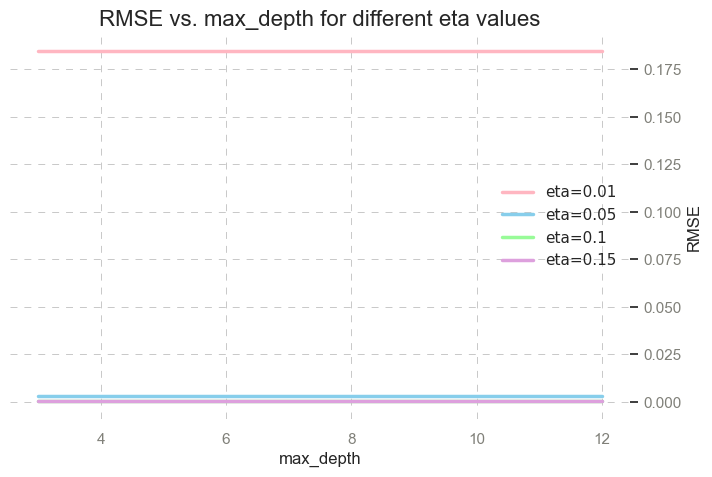

In [42]:
# style
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#FFB6C1', '#87CEEB', '#98FB98', '#DDA0DD'] 
for eta, color in zip(eta_values, colors):
    df_subset = df_scores[df_scores['eta'] == eta]
    ax.plot(df_subset['max_depth'], df_subset['rmse'], 
            label=f'eta={eta}', 
            color=color,
            linewidth=2.5)

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14

# title, label
plt.title('RMSE vs. max_depth for different eta values', fontsize=16)
plt.xlabel('max_depth', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# axis
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False) 
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]
ax.legend(frameon=False)

plt.show()

XGBoost MSE on the Validation Set: 0.0000
XGBoost MAE on the Validation Set: 0.0001
XGBoost R² Score on the Validation Set: 1.0000


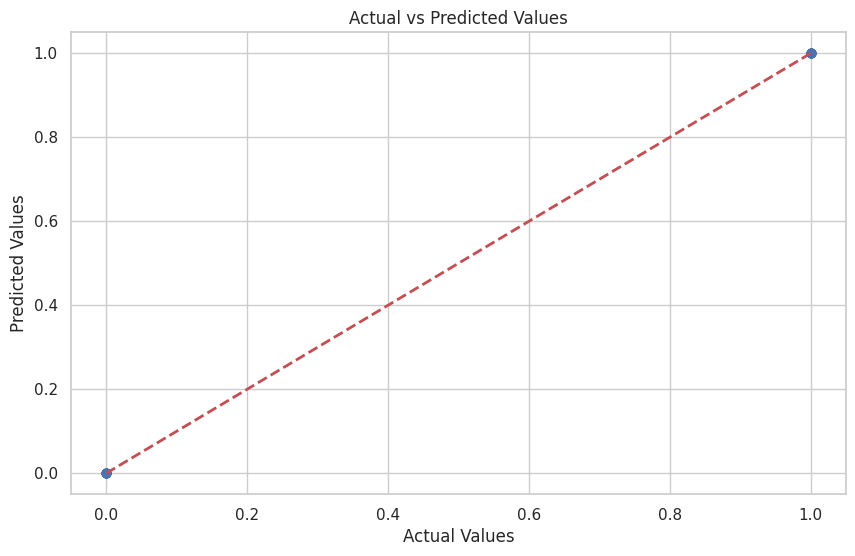

In [47]:
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score

# apply best metrics 
model_xgb = xgb.XGBRegressor(
    eta=float(best_eta),
    max_depth=int(best_max_depth),
    min_child_weight=int(best_min_child_weight),
    objective='reg:squarederror', 
    eval_metric='rmse',           
    nthread=8,
    seed=1,
    verbosity=1
)

# train
model_xgb.fit(X_train, y_train)

# pred
y_pred = model_xgb.predict(X_val)

# evaluate
mse = mean_squared_error((y_val), y_pred)
mae = mean_absolute_error((y_val), y_pred)
r2 = r2_score((y_val), y_pred)

print(f"XGBoost MSE on the Validation Set: {mse:.4f}")
print(f"XGBoost MAE on the Validation Set: {mae:.4f}")
print(f"XGBoost R² Score on the Validation Set: {r2:.4f}")

# plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], 
         [y_val.min(), y_val.max()], 
         'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

plt.show()